In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from scipy import stats

In [2]:
def make_mu(n):
    return np.zeros(shape=(n,1)).squeeze()

def make_kernel(a, b=None):
    k = RBF()
    if b is None:
        return k(a) + np.diag(np.ones(a.shape[0])*1e-6)
    else:
        return k(a, b)

In [10]:
def conditional(x, x_given, y_given):
    s_new_given = make_kernel(x, x_given)
    s_given = make_kernel(x_given)
    s_new = make_kernel(x)
    mu_given = y_given.mean()
    mu_new =  s_new_given.dot(np.linalg.inv(s_given)).dot(y_given)
    
    mu = s_new_given.dot(np.linalg.inv(s_given)).dot(y_given-mu_given) + mu_new
    sig = s_new - s_new_given.dot(np.linalg.inv(s_given)).dot(s_new_given.T)
    return (mu.squeeze(), sig.squeeze())
    

In [27]:
def plot_conditional(x, given=None, n_iters=5, n_priors=100):
    
    if given is None:
        
        given = []
        
        mu_prior = make_mu(len(x)).squeeze()
        sig_prior = make_kernel(x)
        f_prior = np.random.multivariate_normal(mu_prior, sig_prior, n_priors).T
        
        plt.subplot(211, title="GP")
        plt.plot(x, f_prior)
        
        delta = np.max(mu_prior.mean()) - mu_prior.mean()
        sig = np.sqrt(sig_prior.diagonal())
        z = delta / sig
        ei = delta*stats.norm.cdf(z) + sig*stats.norm.pdf(z)
        ei_max = ei.max()
        x_new = x[np.argmax(ei), 0]
        y_new = np.random.normal()
        given.append((x_new, y_new))

        plt.subplot(212, title="Acquisition Function")
        plt.plot(x, ei)
        plt.plot(x_new, ei_max, "ro")
        
        plt.subplots_adjust(hspace=0.5)
        plt.show()
        
        plot_conditional(x, given)
    
    else:
        i = 0
        while i < n_iters:
            
            temp = np.array(given)
            x_given = temp[:, 0].reshape(-1,1)
            y_given = temp[:, 1].reshape(-1,1)
            mu_cond, sig_cond = conditional(x, x_given=x_given, y_given=y_given)
            f_posterior = np.random.multivariate_normal(mu_cond, sig_cond, n_priors).T
            
            plt.subplot(211, title="GP")
            plt.plot(x, f_posterior)
            
            delta = np.max(y_given) - mu_cond.mean()
            sig = np.sqrt(sig_cond.diagonal())
            z = delta / sig
            ei = delta*stats.norm.cdf(z) + sig*stats.norm.pdf(z)
            ei_max = ei.max()
            x_new = x[np.argmax(ei), 0]
            y_new = np.random.normal()
            given.append((x_new, y_new))
            
            plt.subplot(212, title="Acquisition Function")
            plt.plot(x, ei)
            plt.plot(x_new, ei_max, "ro")
            plt.subplots_adjust(hspace=0.5)
            plt.savefig("blah{}.png".format(i+1))
            
            plt.show()
            
            i = i + 1

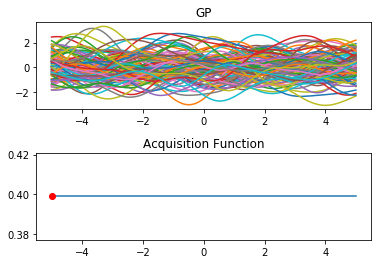

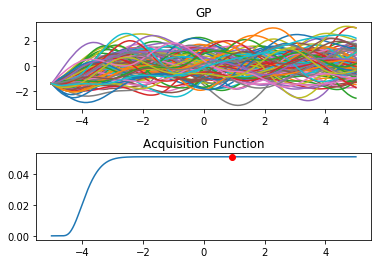

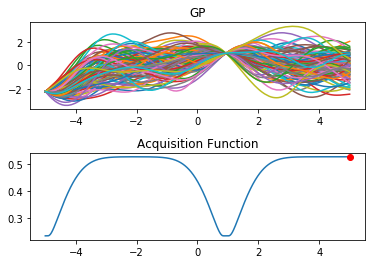

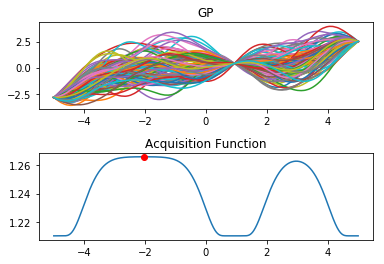

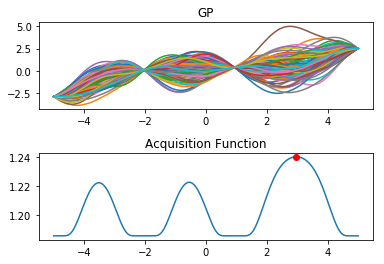

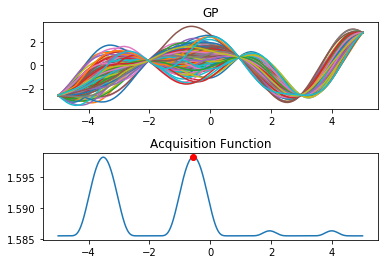

In [28]:
x = np.linspace(-5, 5, 1000).reshape(-1,1)
plot_conditional(x)